In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [3]:
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o", "combined" : "g"}
kernel_alpha = {"linear" : 1/3, "non-linear" : 2/3, "LReg" : "o", "combined" : "g"}
direction_colors = ["r", "b"]
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [9, 8]
method_markers = ["o", "."]
marker_meaning = {9 : "forward", 8 : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/2, False: 1}

In [4]:
def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [pair for pair in df.values]
    
    return similar_pairs

def get_pair_df(pair, df):
    forward_match = ((df.model_node==pair[0])&(df.test_node==pair[1]))
    backward_match = ((df.model_node==pair[1])&(df.test_node==pair[0]))
    regex_model_types = "|".join(["kernel=\'linear\'", "SVR"])
    model_type_match = (df.model.str.contains(regex_model_types, regex=True))
    forward_df = df.loc[forward_match & model_type_match]
    backward_df = df.loc[backward_match & model_type_match]
    return {str((pair[0], pair[1])) : forward_df, str((pair[1], pair[0])) : backward_df}

def get_linear_non_linear_df(df):
    df_linear = df.loc[df.model.str.contains("kernel=\'linear\'")]
    df_non_linear = pd.concat([df,df_linear]).drop_duplicates(keep=False)
    return df_linear, df_non_linear

In [5]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(sample_id, data):
    stats = {}
        
    for experiment in range(1,4):
        with PdfPages(f'results/figures/{sample_id}_experiment_{experiment}.pdf') as pdf:
            print(f"Experiment {experiment}")
            experiment_stats = pd.DataFrame(columns = data.discrepancy.describe().index)
            df = data.loc[data.experiment==experiment]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False))) 
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            pair_dfs = [get_pair_df(pair, df) for pair in similar_pairs[::2]]

            n_pairs = len(pair_dfs)

            xlabel = "Discrepancy"
            ylabel = "Coefficient of Determination"

            for pair_index in range(n_pairs):
                forward_pair, backward_pair = pair_dfs[pair_index].keys()
                forward_df, backward_df = pair_dfs[pair_index].values()
                pair_df = pd.concat([forward_df, backward_df])

                fig, axs = plt.subplots(nrows = 1, ncols = 1, sharey="row", sharex= "row", figsize= (6, 6))
                fig.suptitle(forward_pair, fontsize =13)
                fig.tight_layout(pad=6)

                experiment_stats.loc[forward_pair] = forward_df.discrepancy.describe().values.T
                experiment_stats.loc[backward_pair] = backward_df.discrepancy.describe().values.T

                for row in pair_df.itertuples(index=False):
                    model_type = [model_types[m] for m in model_types if m in row.model][0]
                    color = kernel_colors[model_type]
                    x, y = round(row.discrepancy,2), round(row.score,2)

                    if row.model_node < row.test_node:
                        direction = 0
                    else:
                        direction = 1 

                    axs.plot(x, y, color, alpha = alpha_norm[row.std], marker = method_markers[0])
                    axs.plot(x, y, color, alpha = alpha_norm[row.std], marker = direction_markers[direction])
                    axs.plot(x, y, "w", alpha = 0.8, marker = method_markers[1])
                    axs.plot([0,x],[y-x,y], color, alpha = 0.3, linestyle = (0, (1, 1)))

                axs.set_ylabel(ylabel)
                axs.set_xlabel(xlabel)
                axs.set_ylim([0,1.1])
#                 axs.set_xlim([0,1.0])
                x, y = [x], [y]
                
                usability_line = axs.plot([0,1.1],[0,1.1],c = "g", linestyle= "--", alpha=0.5)
                kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 1, linewidth=5) for k in ["linear","non-linear"]]
                std_lines = [Line2D(x, y, c= "b", alpha = alpha_norm[True], linewidth=5)]
                
                threshold_lines = []
                forward_direction_line = Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = 9, linewidth = 0)
                backward_direction_line = Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = 8, linewidth = 0)
                inner_point = Line2D(x, y, c= "w", alpha = 0.8, marker = method_markers[1], linewidth = 0)

                threshold_lines.append((Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = method_markers[0], linewidth = 0),
                                        forward_direction_line, inner_point))
                threshold_lines.append((Line2D(x, y, c= "b", alpha = alpha_norm[row.std], marker = method_markers[0], linewidth = 0),
                                        backward_direction_line, inner_point))

                lines = std_lines + kernel_lines + usability_line + threshold_lines
                text = ["std", "linear", "non-linear", "equilibrium"]
                
                mean, std, minimum, maximum = experiment_stats.loc[forward_pair][["mean", "std", "min", "max"]]
                forward_statistics_text =f"\nmin={round(minimum,2)} max={round(maximum,2)} \nmean={round(mean,2)} std={round(std,2)}"
                
                mean, std, minimum, maximum = experiment_stats.loc[backward_pair][["mean","std", "min", "max"]]
                backward_statistics_text =f"\nmin={round(minimum,2)} max={round(maximum,2)} \nmean={round(mean,2)} std={round(std,2)}"

                mmd_threshold = pair_df.mmd_score.values[0]
                ocsvm_thresholds = forward_df.ocsvm_score.values[0], backward_df.ocsvm_score.values[0]
                
                text.append(f"forward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[0]})" + 
                            forward_statistics_text)
                text.append(f"backward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[1]})"+ 
                            backward_statistics_text)
                
                l1 = plt.legend(lines, text[:4])
                l2 = plt.legend(threshold_lines, text[4:], bbox_to_anchor=(0.5, 0.5, 0, 1.5),
                                loc="center", borderaxespad=0)
                axs.add_artist(l1)
                axs.add_artist(l2)
                pdf.savefig(fig)
                plt.show()
        
        stats[experiment] = experiment_stats
    return stats

Experiment 1


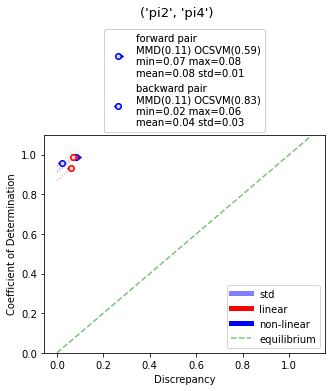

Experiment 2


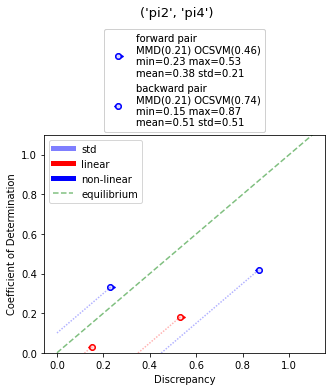

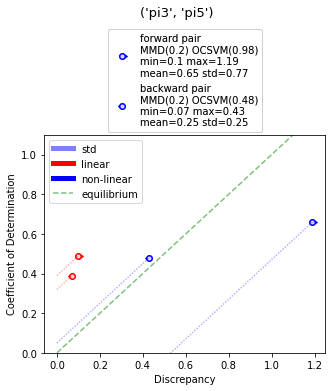

Experiment 3


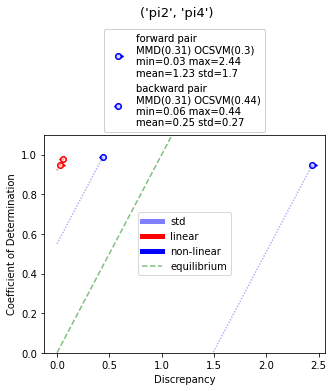

Experiment 1


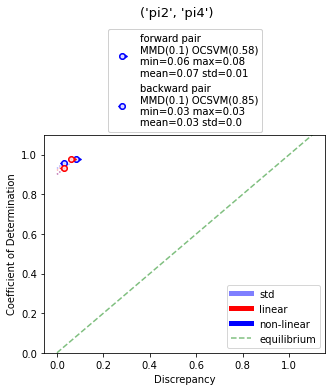

Experiment 2


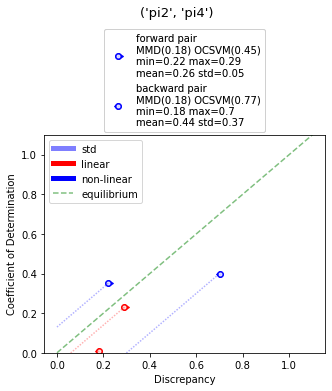

Experiment 3


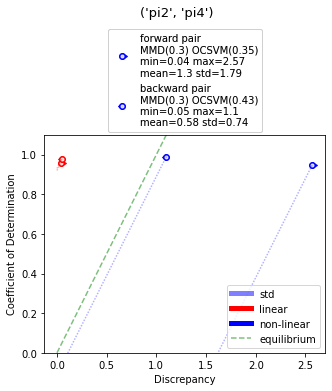

Experiment 1


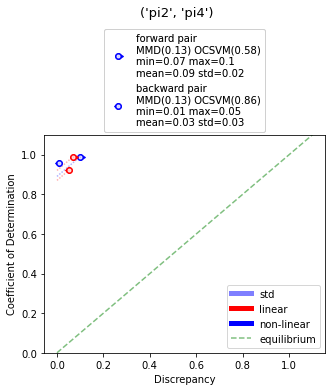

Experiment 2


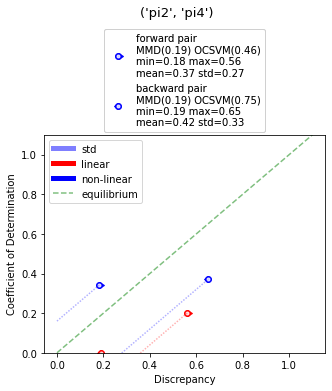

Experiment 3


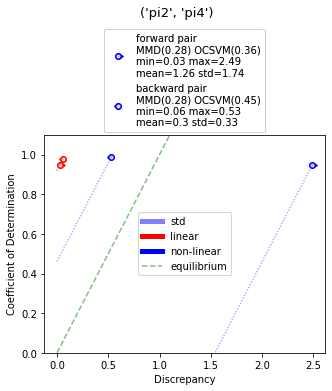

Experiment 1


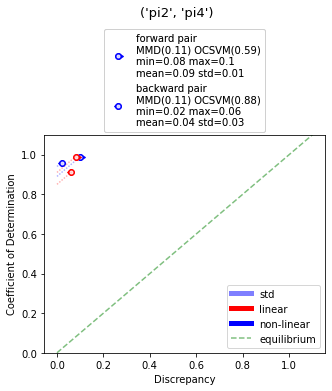

Experiment 2


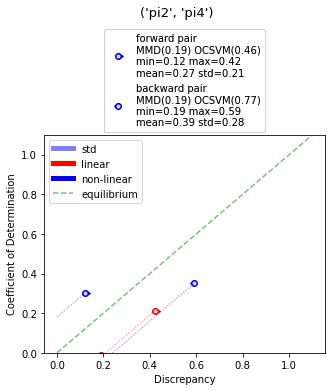

Experiment 3


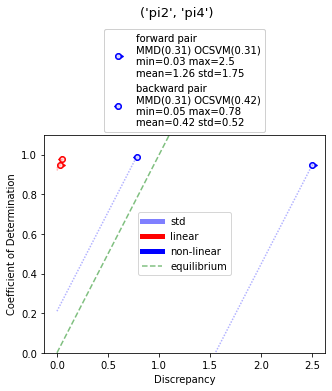

In [7]:
for i in range(1,5):
    sample_id = f"sample_{i}"
    sample_1 = pd.read_csv(f"results/original/{sample_id}.csv") 
    sample_1_stats = plot_r2_discrpenacy(sample_id, sample_1)